# **Traffic Light Optimization using Reinforcement Learning**
### **Pushp Raj Choudhary**
### **23b2152**

## **Source of Data**
The data for this project is extracted using **SUMO (Simulation of Urban MObility)**. SUMO provides real-time traffic simulation data through XML configuration files and the TraCI API.

## **Understanding SUMO and Its Configuration**

### **What is SUMO?**

**SUMO (Simulation of Urban MObility)** is an open-source, microscopic traffic simulator that models **urban and highway traffic dynamics** in a **realistic and highly customizable** manner. It enables:

- **Traffic Flow Simulation**: Models vehicle movement and traffic congestion.
- **Traffic Signal Control**: Implements **fixed, adaptive, or RL-based** traffic lights.
- **Emission Analysis**: Evaluates **pollution levels** caused by vehicle movement.
- **Floating Car Data (FCD) Output**: Extracts **detailed vehicle movement data**.
- **Multi-Modal Simulation**: Includes cars, buses, bicycles, pedestrians, and rail networks.

SUMO is widely used for:

- **Traffic optimization and management**.
- **Autonomous vehicle development**.
- **Environmental impact assessment**.
- **Reinforcement Learning (RL)-based traffic control**.

### **How SUMO Works**

SUMO uses **XML configuration files** to define the simulation setup. These files include:

1. **Network File (`.net.xml`)**: Defines the **road layout, lanes, intersections, and speed limits**.
2. **Route File (`.rou.xml`)**: Specifies **vehicle types, entry points, and movement patterns**.
3. **Traffic Signal File (`.tll.xml`)**: Configures **traffic light phases and timings**.
4. **SUMO Configuration File (`.sumocfg`)**: The **main entry point**, which loads all necessary files and defines simulation parameters like:
   - **Simulation start & end time**.
   - **Logging and output settings**.
   - **GUI options for visualization**.

---

### **Generated Output Files and Their Use Cases**
SUMO generates multiple **output files** that provide **detailed traffic insights**. Below are the key output files and their relevance.

#### **1. Traffic Light State Data (`traffic_lights_extracted.csv`)**
- **Extracted via TraCI API** to analyze signal efficiency.
- **Contains:**
  - `Timestep`: Simulation step number.
  - `Traffic_Light_ID`: Unique identifier for each traffic signal.
  - `State`: Current traffic light state (`rGrG`, `GGrr`, etc.).
  - `Phase_Duration`: Time (in seconds) for which a traffic light remains in its current phase.

##### **Why This Data is Important?**
- Helps in optimizing **traffic light timings**.
- Identifies **inefficient signals causing congestion**.
- **Key input for RL models** to dynamically optimize signal control.

---

#### **2. Emission Data (`emission_output.xml` or `.csv`)**
- Tracks **vehicle emissions** during the simulation.
- **Contains:**
  - `Vehicle ID`
  - `CO2 (g/s)`, `CO (g/s)`, `NOx (g/s)`, `PMx (g/s)`
  - `Fuel Consumption (ml/s)`
  - `Speed (m/s)`

##### **Why This Data is Important?**
- **Environmental Impact Analysis**: Evaluates the **carbon footprint** of traffic.
- **Policy Decision Making**: Helps cities enforce **eco-friendly transport policies**.
- **Fuel Efficiency Studies**: Useful for optimizing fuel usage via **adaptive traffic control**.
- **RL Use Case**: The **reward function** in RL-based signal optimization can penalize **high emissions** and encourage **eco-friendly routing**.

---

#### **3. Floating Car Data (FCD) Output (`fcd_output.xml` or `.csv`)**
- Logs **real-time vehicle movement data**.
- **Contains:**
  - `Vehicle ID`
  - `Position (x, y)`
  - `Speed`
  - `Acceleration`
  - `Lane ID`
  - `Waiting Time`
  - `Route Information`

##### **Why This Data is Important?**
- **Traffic Flow Analysis**: Monitors vehicle **movement patterns**.
- **Congestion Detection**: Identifies **bottlenecks** in real-time.
- **Driver Behavior Study**: Examines vehicle **speed variations** and **stopping patterns**.
- **RL Use Case**: Can be used to train **deep reinforcement learning (DRL) models** to predict **optimal traffic light sequences**.

---

#### **4. Edge-Based Traffic Flow Data**
- **Captures vehicle flow statistics per road segment**.
- **Contains:**
  - `Edge ID`
  - `Vehicle Count`
  - `Average Speed`
  - `Density`

##### **Why This Data is Useful?**
- Identifies **high-traffic areas**.
- Helps in **dynamic lane management** strategies.
- Supports **urban traffic planning** by optimizing road networks.

---

### **How This Data is Used in RL-Based Traffic Signal Control**
The extracted data plays a crucial role in **training Reinforcement Learning (RL) agents** for **adaptive traffic control**.

#### **How RL Works in Traffic Optimization**
- **State Representation:** Uses traffic light states, vehicle count, emissions, and waiting time.
- **Action Space:** Changes in **signal timings and phase transitions**.
- **Reward Function:** Penalizes **high waiting time & emissions**, rewards **smooth traffic flow**.

#### **Potential RL Algorithms for Traffic Control**
1. **Q-Learning**: Simple table-based RL method.
2. **Deep Q-Networks (DQN)**: Uses **Neural Networks** for better generalization.
3. **Proximal Policy Optimization (PPO)**: Balances exploration & exploitation.
4. **Multi-Agent RL**: Models **multiple intersections working together**.

By leveraging SUMO data, **AI-driven traffic optimization** can **reduce congestion, lower emissions, and improve road efficiency**.

---

### **Why SUMO Was Used Here?**
SUMO is **highly flexible, scalable, and ideal for integrating AI-based optimization**:
✔ **Realistic Traffic Simulation**  
✔ **Dynamic Data Extraction via TraCI**  
✔ **Scalability from single intersections to entire cities**  
✔ **Seamless Integration with RL & AI**  

---

### **Next Steps**
- **Data Visualization**: Further analyzing emissions and congestion hotspots.
- **RL Implementation**: Training models for **adaptive traffic light control**.
- **Comparative Study**: Evaluating **fixed vs. AI-controlled traffic lights**.

This comprehensive **SUMO-based framework** lays the foundation for **smart traffic management and intelligent transportation systems (ITS)**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import traci  # for live traffic simulation
import random
import time
import datetime
import pytz
import seaborn as sns
import xml.etree.ElementTree as ET  # For the conversion of xml files into csv for data analysis
import os

### **Starting SUMO and Extracting Traffic Data**
  
To interact with SUMO in real-time, we use **TraCI (Traffic Control Interface)**. This allows us to control traffic lights, extract vehicle states, and modify simulation parameters dynamically.

#### **Steps in the Code**
1. **Start SUMO** using `traci.start()`.
2. **Run the simulation for 3700 steps** (each step is ~1 second).
3. **Extract traffic light states** at each step:
   - `traci.trafficlight.getIDList()`: Retrieves all traffic light IDs.
   - `traci.trafficlight.getRedYellowGreenState(tl)`: Captures the current phase (Red, Yellow, Green).
   - `traci.trafficlight.getPhaseDuration(tl)`: Stores the duration of the current phase.
4. **Save Data:** The extracted data is stored in a Pandas DataFrame and exported to CSV for further analysis.

This data will be used to understand how different signals affect traffic congestion.

In [ ]:
# Start SUMO with TraCI
sumoCmd = ["sumo", "-c", "C:/Users/Pushp Raj Choudhary/2025-03-14-16-24-53/osm.sumocfg", "--start"]
traci.start(sumoCmd)

(21, 'SUMO 1.22.0')

In [ ]:
traffic_light_data = []

# Run SUMO simulation
for step in range(3700):  
    traci.simulationStep()
    
    for tl in traci.trafficlight.getIDList():
        state = traci.trafficlight.getRedYellowGreenState(tl)
        phase_duration = traci.trafficlight.getPhaseDuration(tl)
        
        traffic_light_data.append({
            "Timestep": step,
            "Traffic_Light_ID": tl,
            "State": state,
            "Phase_Duration": phase_duration
        })

traci.close()

In [ ]:
# Convert to DataFrame and save as CSV
df_traffic_lights = pd.DataFrame(traffic_light_data)
df_traffic_lights.to_csv("traffic_lights_extracted.csv", index=False)

# Display Data
display(df_traffic_lights.head())

df_traffic_lights.describe()

,Timestep,Traffic_Light_ID,State,Phase_Duration
0,0,cluster_10279701148_11630151856_663826006,GG,0.001
1,0,cluster_11502623497_1177160337,rrGGg,42.000
2,0,cluster_664446535_8507351666,rrGGG,42.000
3,1,cluster_10279701148_11630151856_663826006,GG,0.001
4,1,cluster_11502623497_1177160337,rrGGg,42.000


,Timestep,Phase_Duration
count,11100.000000,11100.000000
mean,1849.500000,18.281955
std,1068.146075,20.111677
min,0.000000,0.001000
25%,924.750000,0.001000
50%,1849.500000,3.000000
75%,2774.250000,42.000000
max,3699.000000,42.000000


In [3]:
df_traffic_lights=pd.read_csv("C:/Users/Pushp Raj Choudhary/Documents/Coding/Python/Traffic_Simulator/traffic_lights_extracted.csv")

In [94]:
df_traffic_lights.tail(10)

,Timestep,Traffic_Light_ID,State,Phase_Duration,Phase_Type
11090,3696,cluster_664446535_8507351666,rryyy,3.000,Red
11091,3697,cluster_10279701148_11630151856_663826006,GG,0.001,Green
11092,3697,cluster_11502623497_1177160337,GGrrr,42.000,Green
11093,3697,cluster_664446535_8507351666,rryyy,3.000,Red
11094,3698,cluster_10279701148_11630151856_663826006,GG,0.001,Green
11095,3698,cluster_11502623497_1177160337,GGrrr,42.000,Green
11096,3698,cluster_664446535_8507351666,rryyy,3.000,Red
11097,3699,cluster_10279701148_11630151856_663826006,GG,0.001,Green
11098,3699,cluster_11502623497_1177160337,GGrrr,42.000,Green
11099,3699,cluster_664446535_8507351666,GGrrr,42.000,Green


In [4]:
df_traffic_lights = df_traffic_lights[df_traffic_lights["Traffic_Light_ID"] != "cluster_10279701148_11630151856_663826006"]   # Remove this traffic light as it is not present (or giving false sense of presence [giving green state always]) in the simulation

In [5]:
df_traffic_lights.tail(10)

,Timestep,Traffic_Light_ID,State,Phase_Duration
11086,3695,cluster_11502623497_1177160337,GGrrr,42.0
11087,3695,cluster_664446535_8507351666,rrGGG,42.0
11089,3696,cluster_11502623497_1177160337,GGrrr,42.0
11090,3696,cluster_664446535_8507351666,rryyy,3.0
11092,3697,cluster_11502623497_1177160337,GGrrr,42.0
11093,3697,cluster_664446535_8507351666,rryyy,3.0
11095,3698,cluster_11502623497_1177160337,GGrrr,42.0
11096,3698,cluster_664446535_8507351666,rryyy,3.0
11098,3699,cluster_11502623497_1177160337,GGrrr,42.0
11099,3699,cluster_664446535_8507351666,GGrrr,42.0


### **Converting XML to CSV for Data Analysis**
SUMO outputs raw data in XML format, which is **not directly usable for analysis**. To process this data efficiently, we convert it to CSV.

#### **Why XML-to-CSV Conversion?**
- XML files store hierarchical data, making extraction complex.
- CSV format allows easy analysis with **Pandas and visualization tools**.
- Essential for extracting **trip information, FCD, and emissions data**.

#### **Key Steps in XML Parsing**
1. **Parse the XML File**: Using `ElementTree` to read SUMO's XML output.
2. **Extract Relevant Attributes**: Retrieve key metrics like speed, emissions, waiting time, etc.
3. **Store Data in CSV Format**: Saves structured tabular data for easier processing.

This conversion allows further analysis of **traffic efficiency, congestion patterns, and vehicle behavior**.

In [6]:
# Load XML file 
xml_file = "C:/Users/Pushp Raj Choudhary/2025-03-14-16-24-53/tripinfo.xml"

# Parse XML
tree = ET.parse(xml_file)
root = tree.getroot()

# Extract data into a list
trip_data = []
for trip in root.findall("tripinfo"):
    trip_data.append({
        "Vehicle_ID": trip.get("id"),
        "Depart_Time": float(trip.get("depart", 0)),
        "Arrival_Time": float(trip.get("arrival", 0)),
        "Duration": float(trip.get("duration", 0)),
        "Waiting_Time": float(trip.get("waitingTime", 0)),
        "Time_Loss": float(trip.get("timeLoss", 0)),
        "Distance_Traveled": float(trip.get("routeLength", 0)) 
    })

df_trip = pd.DataFrame(trip_data)

df_trip.fillna(0, inplace=True)

csv_output = "tripinfo.csv"
df_trip.to_csv(csv_output, index=False)

print(f"Data extracted and saved to {csv_output}")
display(df_trip.head(10))

Data extracted and saved to tripinfo.csv


,Vehicle_ID,Depart_Time,Arrival_Time,Duration,Waiting_Time,Time_Loss,Distance_Traveled
0,veh0,0.0,55.0,55.0,0.0,16.95,650.14
1,veh5,44.0,86.0,42.0,0.0,3.56,420.90
2,veh5.1,45.0,92.0,47.0,0.0,5.02,420.90
3,veh3,27.0,102.0,75.0,0.0,14.72,823.23
4,veh3.1,30.0,105.0,75.0,0.0,17.87,823.23
5,veh3.2,33.0,112.0,79.0,1.0,19.63,823.23
6,veh1,9.0,123.0,114.0,0.0,27.02,1292.35
7,veh3.3,36.0,128.0,92.0,0.0,18.36,823.23
8,veh3.4,39.0,131.0,92.0,0.0,33.58,823.23
9,veh3.5,42.0,136.0,94.0,0.0,24.81,823.23


In [7]:
# Load XML file
xml_file = "C:/Users/Pushp Raj Choudhary/2025-03-14-16-24-53/fcd_output.xml"

# Parse XML
tree = ET.parse(xml_file)
root = tree.getroot()

# Extract data into a list
fcd_data = []
for timestep in root.findall("timestep"):
    time = float(timestep.get("time", 0))  # Current simulation time

    for vehicle in timestep.findall("vehicle"):
        fcd_data.append({
            "Timestep": time,
            "Vehicle_ID": vehicle.get("id"),
            "Speed": float(vehicle.get("speed", 0)),
            "Lane_ID": vehicle.get("lane", "Unknown"),
            "Edge_ID": vehicle.get("road", "Unknown"),
            "X_Position": float(vehicle.get("x", 0)),
            "Y_Position": float(vehicle.get("y", 0)),
            "Acceleration": float(vehicle.get("acceleration", 0)),
            "Angle": float(vehicle.get("angle", 0))
        })

# Convert to DataFrame
df_fcd = pd.DataFrame(fcd_data)

df_fcd.fillna(0, inplace=True)

csv_output_fcd = "fcd_output.csv"
df_fcd.to_csv(csv_output_fcd, index=False)

print(f"Data extracted and saved to {csv_output_fcd}")
display(df_fcd.head(10))

Data extracted and saved to fcd_output.csv


,Timestep,Vehicle_ID,Speed,Lane_ID,Edge_ID,X_Position,Y_Position,Acceleration,Angle
0,0.0,veh0,0.00,1288011209_1,Unknown,824.43,305.79,0.0,240.79
1,1.0,veh0,2.49,1288011209_1,Unknown,822.25,304.58,0.0,240.79
2,2.0,veh0,4.36,1288011209_1,Unknown,818.45,302.45,0.0,240.79
3,3.0,veh0,6.90,1288011209_1,Unknown,812.43,299.08,0.0,240.79
4,4.0,veh0,9.12,1288011209_1,Unknown,804.47,294.63,0.0,240.79
5,5.0,veh0,11.55,1288011209_1,Unknown,794.39,289.00,0.0,240.79
6,6.0,veh0,11.42,1288011209_1,Unknown,784.42,283.43,0.0,240.79
7,7.0,veh0,10.80,1288011209_1,Unknown,775.00,278.16,0.0,240.79
8,8.0,veh0,11.73,1288011209_1,Unknown,764.76,272.44,0.0,240.79
9,9.0,veh0,11.43,:cluster_11158897100_11158897101_11158897102_6...,Unknown,754.33,268.17,0.0,256.86


In [8]:
# Load XML file
xml_file = "C:/Users/Pushp Raj Choudhary/2025-03-14-16-24-53/emission.xml"
tree = ET.parse(xml_file)
root = tree.getroot()

# Extract data into a list
emission_data = []
for timestep in root.findall("timestep"):
    time = float(timestep.get("time", 0))

    for vehicle in timestep.findall("vehicle"):
        emission_data.append({
            "Timestep": time,
            "Vehicle_ID": vehicle.get("id"),
            "CO2_Emission": float(vehicle.get("CO2", 0)),
            "Fuel_Consumption": float(vehicle.get("fuel", 0)),
            "NOx_Emission": float(vehicle.get("NOx", 0)),
            "PMx_Emission": float(vehicle.get("PMx", 0))
        })

df_emission = pd.DataFrame(emission_data)
df_emission.fillna(0, inplace=True)  

# Save for future analysis
df_emission.to_csv("emission.csv", index=False)
display(df_emission.head())

,Timestep,Vehicle_ID,CO2_Emission,Fuel_Consumption,NOx_Emission,PMx_Emission
0,0.0,veh0,2624.72,837.22,1.20,0.07
1,1.0,veh0,3969.80,1266.22,1.77,0.09
2,2.0,veh0,4324.03,1379.19,1.89,0.09
3,3.0,veh0,6690.76,2134.04,2.94,0.14
4,4.0,veh0,7355.01,2345.90,3.19,0.15


In [9]:
# Merge all three datasets on Vehicle_ID and Timestep where applicable
df_combined = df_fcd.merge(df_trip, on="Vehicle_ID", how="left")\
                     .merge(df_emission, on=["Vehicle_ID", "Timestep"], how="left")\
                     .merge(df_traffic_lights, on="Timestep", how="left")

df_combined.fillna(0, inplace=True)  
df_combined.to_csv("combined_sumo_data2.csv", index=False)

display(df_combined.head())

,Timestep,Vehicle_ID,Speed,Lane_ID,Edge_ID,X_Position,Y_Position,Acceleration,Angle,Depart_Time,...,Waiting_Time,Time_Loss,Distance_Traveled,CO2_Emission,Fuel_Consumption,NOx_Emission,PMx_Emission,Traffic_Light_ID,State,Phase_Duration
0,0.0,veh0,0.00,1288011209_1,Unknown,824.43,305.79,0.0,240.79,0.0,...,0.0,16.95,650.14,2624.72,837.22,1.20,0.07,cluster_11502623497_1177160337,rrGGg,42.0
1,0.0,veh0,0.00,1288011209_1,Unknown,824.43,305.79,0.0,240.79,0.0,...,0.0,16.95,650.14,2624.72,837.22,1.20,0.07,cluster_664446535_8507351666,rrGGG,42.0
2,1.0,veh0,2.49,1288011209_1,Unknown,822.25,304.58,0.0,240.79,0.0,...,0.0,16.95,650.14,3969.80,1266.22,1.77,0.09,cluster_11502623497_1177160337,rrGGg,42.0
3,1.0,veh0,2.49,1288011209_1,Unknown,822.25,304.58,0.0,240.79,0.0,...,0.0,16.95,650.14,3969.80,1266.22,1.77,0.09,cluster_664446535_8507351666,rrGGG,42.0
4,2.0,veh0,4.36,1288011209_1,Unknown,818.45,302.45,0.0,240.79,0.0,...,0.0,16.95,650.14,4324.03,1379.19,1.89,0.09,cluster_11502623497_1177160337,rrGGg,42.0


## **Grouping Lanes for Better Visualization**
The dataset originally contained a **large number of lanes**, making the visualizations cluttered and difficult to interpret.

#### **Why Did We Group Lanes?**
- **Simplifies Analysis**: Reduces complexity in visual representation.
- **Enhances Interpretability**: Easier to spot trends and patterns.
- **Avoids Overlapping Plots**: Too many individual lanes would make the graphs unreadable.
- **Focuses on Key Insights**: Helps analyze traffic flow and congestion **without unnecessary noise**.

By grouping lanes together, we can **extract meaningful insights** while maintaining **clarity in the visualizations**.

In [10]:
# Get unique lane IDs and sort them
unique_lanes = sorted(df_combined["Lane_ID"].unique())

# Define the number of lanes per group
lanes_per_group = 50

# Create dynamic lane groups
lane_groups = {}
for i in range(0, len(unique_lanes), lanes_per_group):
    group_name = f"{i//lanes_per_group + 1}"
    lane_groups[group_name] = unique_lanes[i:i + lanes_per_group]

# Assign each lane to its respective group
def assign_lane_group(lane):
    for group, lanes in lane_groups.items():
        if lane in lanes:
            return group
    return "Other"

df_combined["Lane_Group"] = df_combined["Lane_ID"].apply(assign_lane_group)

# Convert lane groups to a DataFrame and save
df_lane_groups = pd.DataFrame.from_dict(lane_groups, orient='index').transpose()
df_lane_groups.to_csv("lane_groups.csv", index=False)
display(df_lane_groups.head(5))

,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
0,-101757243_0,-101966488#2_0,-103082314#0_0,-1275560130_0,101966393#2_0,101972917_0,102690997#2_0,103082316#1_0,1124102312_0,1132632802#0_0,...,:1177211769_10_0,:1187083489_3_0,:1190100487_0_0,:1190128320_6_0,:664446129_0_0,:664472707_2_0,:cluster_10279701141_1177160864_664472702_3_0,:cluster_10281958925_10281958926_6508834064_65...,:cluster_11158897100_11158897101_11158897102_6...,:cluster_1189036471_1189036770_9_0
1,-101757273#0_0,-101966492_0,-103082314#1_0,-1275560131_0,101966396_0,101972924#0_0,102690997#3_0,103082317#0_0,1124105437_0,1132632802#1_0,...,:1177211769_4_0,:1189036468_0_0,:1190100498_3_0,:1190128320_7_0,:664446129_1_0,:664472707_3_0,:cluster_10279701141_1177160864_664472702_4_0,:cluster_10281958925_10281958926_6508834064_65...,:cluster_11158897100_11158897101_11158897102_6...,:cluster_1190128316_1190128344_1_0
2,-101757273#1_0,-101966494_0,-103082314#2_0,-1309211043_0,101966397_0,101972924#2_0,102690997#4_0,103082317#1_0,1124105783_0,1132632803_0,...,:1177211771_0_0,:1189036518_4_0,:1190128192_1_0,:1190128320_9_0,:664446130_0_0,:664472733_4_0,:cluster_10279701141_1177160864_664472702_4_1,:cluster_10281958925_10281958926_6508834064_65...,:cluster_11158897100_11158897101_11158897102_6...,:cluster_1190128316_1190128344_6_0
3,-101757273#2_0,-101966506#0_0,-103082314#3_0,-52152309#0_0,101966424#1_0,101972924#3_0,102690997#5_0,103082317#2_0,1124379125_0,1137238825_0,...,:1177211771_13_0,:1189036526_0_0,:1190128194_10_0,:1190128334_0_0,:664446130_2_0,:664472733_5_0,:cluster_10279701141_1177160864_664472702_7_0,:cluster_10281958925_10281958926_6508834064_65...,:cluster_11158897100_11158897101_11158897102_6...,:cluster_1190128316_1190128344_8_0
4,-101757288_0,-101966506#1_0,-103082314#4_0,-52155576#0_0,101966424#2_0,101972924#5_0,102691001#0_0,103082317#3_0,1124379125_1,1147855373_0,...,:1177211771_16_0,:1189036539_0_0,:1190128194_12_0,:1190128334_10_0,:664446130_3_0,:664472733_7_0,:cluster_10279701141_1177160864_664472702_8_0,:cluster_10281958925_10281958926_6508834064_65...,:cluster_11158897100_11158897101_11158897102_6...,:cluster_11942000232_664472748_1_0


## **Traffic Density Over Time**
This plot shows how **the number of vehicles** in the network changes over time.

#### **How This Data Was Generated**
- Used SUMO’s **traffic scaling** to **increase congestion** artificially.
- Initially set a **higher scale**, leading to **heavy traffic buildup**.
- Later reduced the scale back to **1**, allowing congestion to clear.

#### **Key Observations**
1. **Sharp Increase (0 - 1500 timesteps)**: Vehicles enter rapidly, causing **heavy congestion**.
2. **Steep Decline (1500 - 2000 timesteps)**: Traffic scale is reduced, and vehicles exit faster.
3. **Stable Phase (2000+ timesteps)**: The system returns to **normal traffic conditions**.

#### **Why Is This Useful?**
- Helps analyze **peak congestion periods** and **network capacity**.
- Demonstrates how **traffic control strategies** can help in decongestion.
- Can be used for **traffic light optimization** to prevent excessive build-up.

This provides insights for **adaptive traffic signal control and urban planning**.

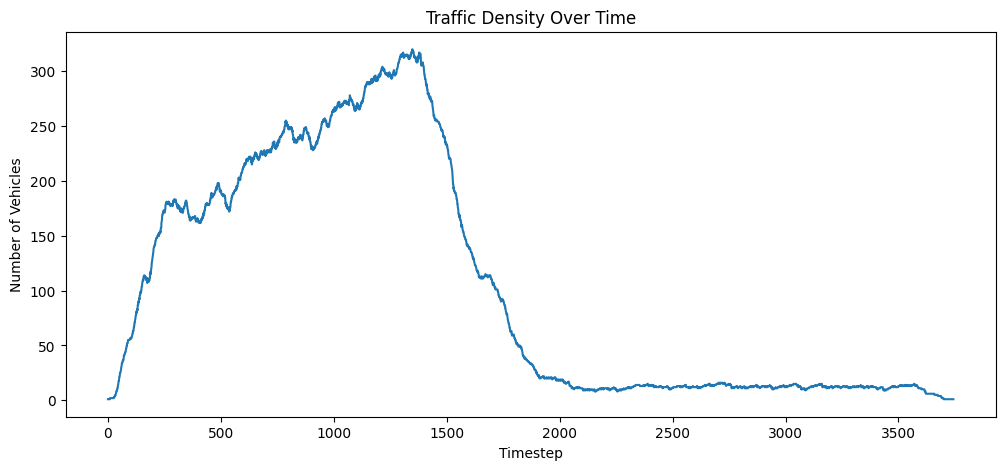

In [78]:
plt.figure(figsize=(12, 5))
sns.lineplot(x="Timestep", y="Vehicle_ID", data=df_fcd.groupby("Timestep").count().reset_index())
plt.title("Traffic Density Over Time")
plt.xlabel("Timestep")
plt.ylabel("Number of Vehicles")
plt.show()

## **Speed Variance Across Lane Groups**
This box plot visualizes **speed distribution** across different lane groups.

#### **Key Observations**
1. **Speed Distribution**:
   - Most lane groups have a **wide range of speeds**, with significant variance.
   - Some lanes show **low median speeds**, possibly indicating congestion.
   - Outliers (dots) suggest instances of **sudden accelerations or stops**.

2. **Lane-Specific Trends**:
   - Certain lanes exhibit **higher overall speeds**, likely indicating **faster-moving traffic**.
   - Some lanes have **lower speeds with high variance**, suggesting **frequent stop-and-go movement**.

#### **Why Is This Useful?**
- Identifies **bottlenecks** where traffic slows down significantly.
- Helps analyze **lane-based congestion patterns**.
- Can be used for **adaptive lane management** and **traffic flow optimization**.

This data can be leveraged for **dynamic speed limit adjustments** and **better traffic light coordination** to ensure **smoother traffic movement**.

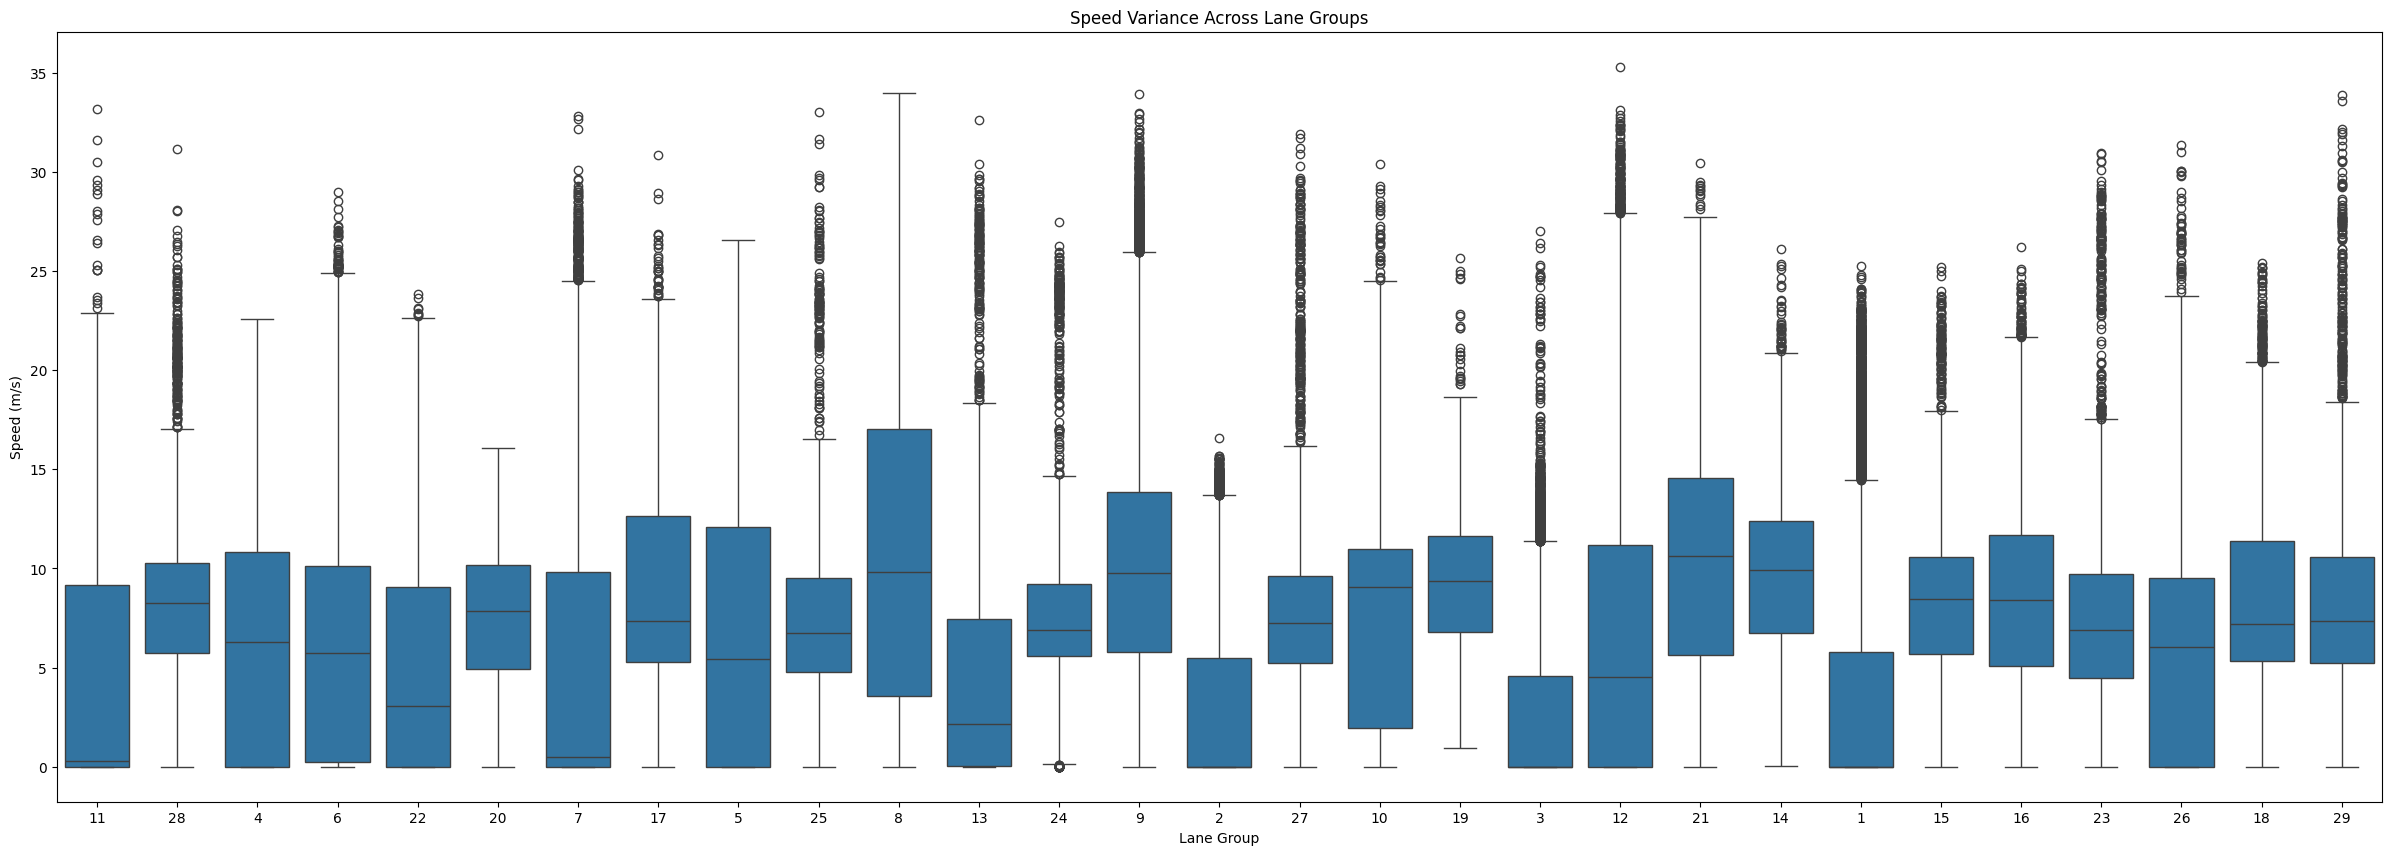

In [79]:
plt.figure(figsize=(30, 10))
sns.boxplot(x="Lane_Group", y="Speed", data=df_combined)
plt.title("Speed Variance Across Lane Groups")
plt.xlabel("Lane Group")
plt.ylabel("Speed (m/s)")
plt.show()

## **Speed Distribution Across Lane Groups (Strip Plot)**
This strip plot visualizes **individual vehicle speeds** across different lane groups.

#### **Key Observations**
1. **Speed Spread**:
   - Vehicles exhibit **varying speeds** across different lane groups.
   - Some lanes have a **denser spread at lower speeds**, indicating **congestion or frequent stops**.
   - Other lanes show **higher speeds with less variation**, suggesting **smoother traffic flow**.

2. **Outliers and Variability**:
   - **Vertical spread** in each lane group shows **speed variance**.
   - Lanes with **more outliers at higher speeds** might represent **express lanes or low-traffic areas**.
   - Clusters of **low-speed points** may indicate **bottlenecks** or **traffic signal delays**.

#### **Why Is This Useful?**
- Helps **identify lanes with irregular traffic flow**.
- Highlights potential areas for **lane management improvements**.
- Useful for **analyzing speed consistency** across different parts of the network.

This data can inform **adaptive traffic control systems**, ensuring **efficient traffic movement** while minimizing delays.

C:\Users\Pushp Raj Choudhary\AppData\Local\Temp\ipykernel_7884\903147106.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="Lane_Group", y="Speed", data=df_combined, jitter=True, palette="husl", alpha=0.6)


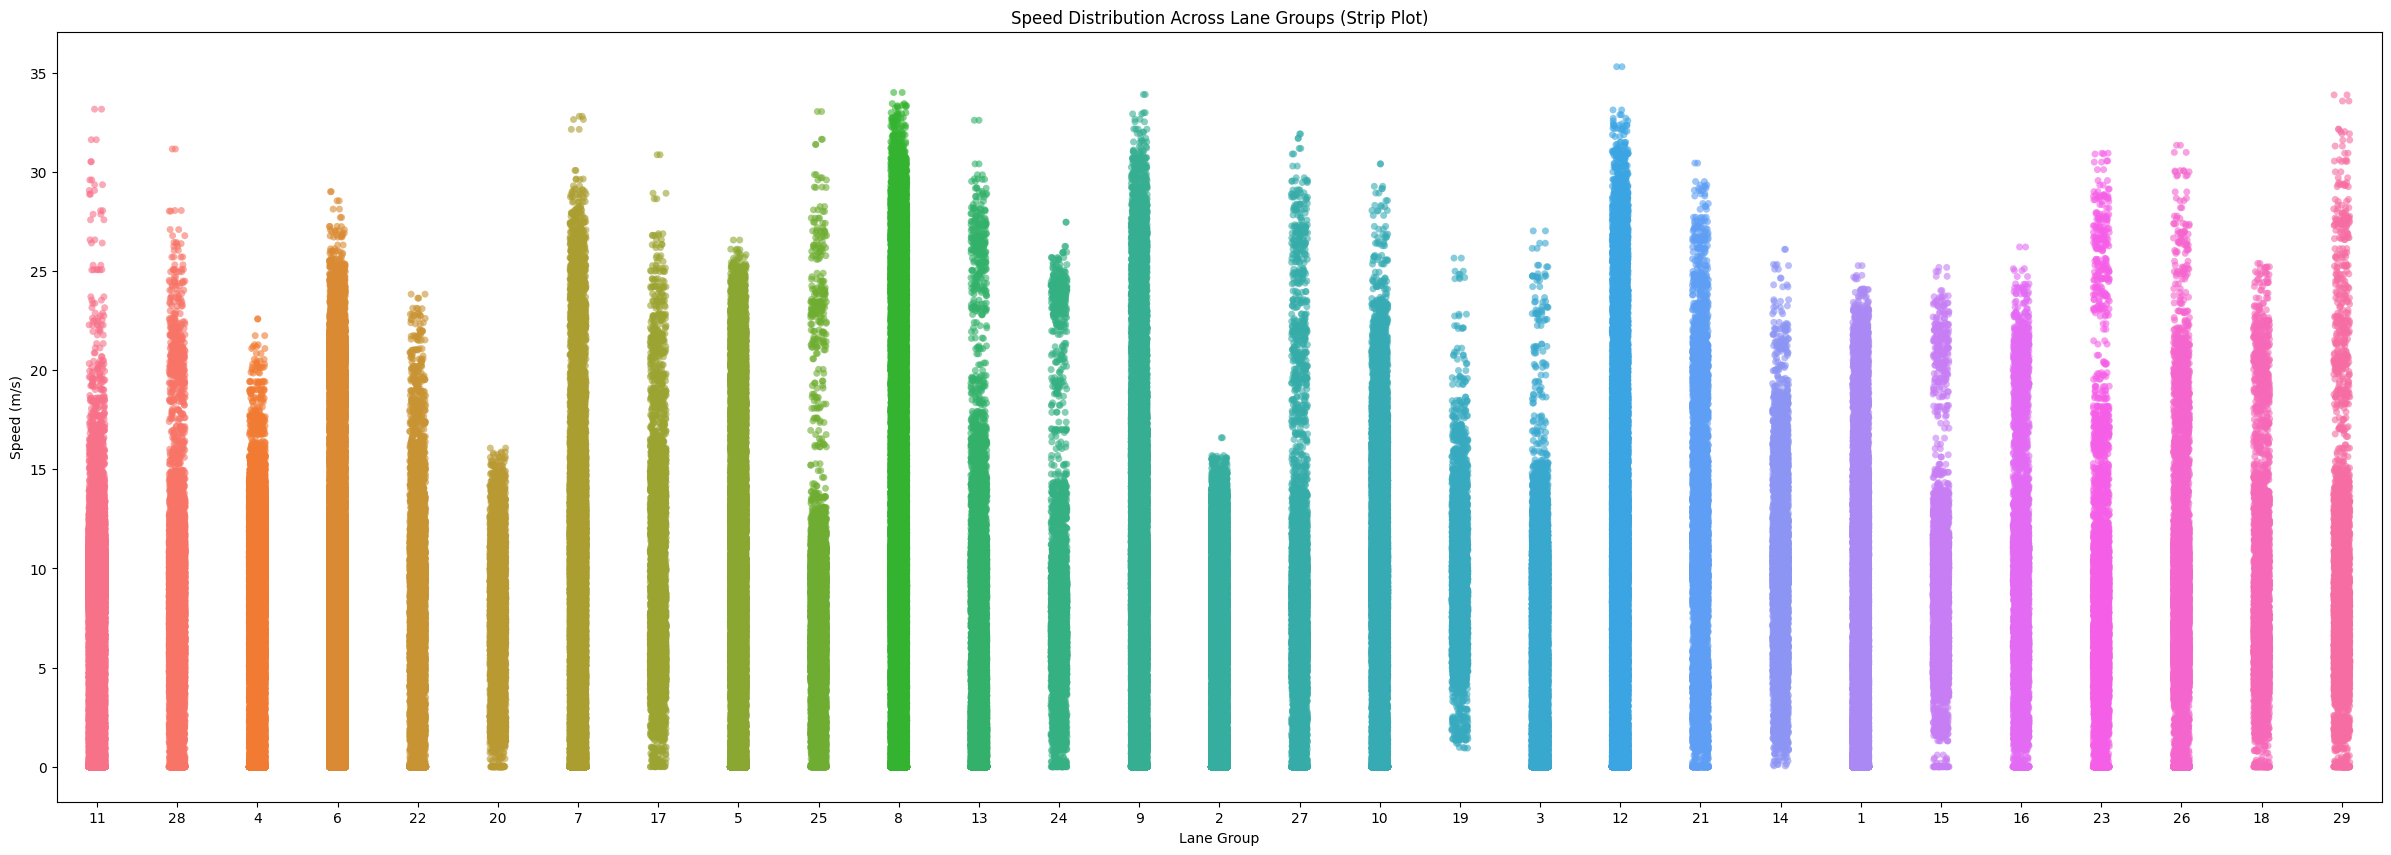

In [113]:
plt.figure(figsize=(30, 10))
sns.stripplot(x="Lane_Group", y="Speed", data=df_combined, jitter=True, palette="husl", alpha=0.6)
plt.title("Speed Distribution Across Lane Groups (Strip Plot)")
plt.xlabel("Lane Group")
plt.ylabel("Speed (m/s)")
plt.show()

## **Travel Duration Distribution**
This histogram shows the **distribution of travel durations** for vehicles in the network.

#### **Trend Analysis**
- **Peak around 150-200s**: Most vehicles complete trips within this range.
- **Gradual decline beyond 200s**: Indicates longer trips are less frequent.
- **Multiple smaller peaks**: Suggests variations due to traffic signals, congestion, or different route types.
- **Long-tail effect (600s+)**: Some vehicles experience significantly longer travel times, possibly due to congestion or inefficient routing.

This trend helps analyze **traffic efficiency** and identify **bottlenecks in the network**.

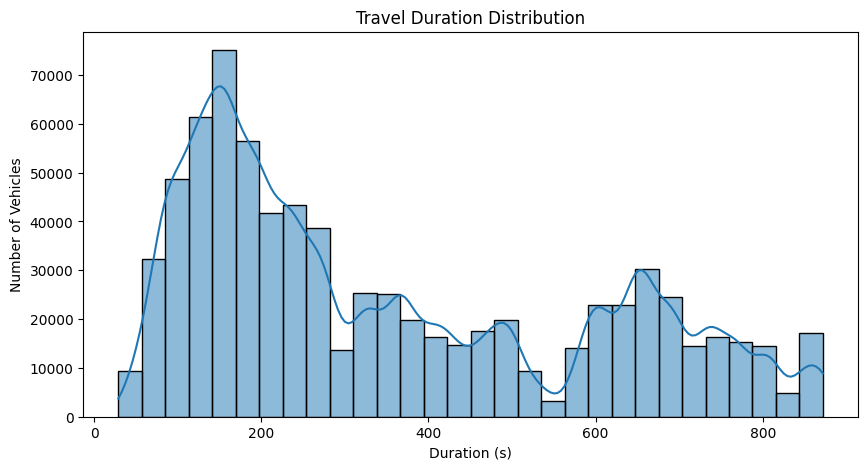

In [117]:
plt.figure(figsize=(10, 5))
sns.histplot(df_combined["Duration"], bins=30, kde=True)
plt.title("Travel Duration Distribution")
plt.xlabel("Duration (s)")
plt.ylabel("Number of Vehicles")
plt.show()

## **Travel Distance Distribution**
This histogram shows the **distribution of distances traveled** by vehicles.

#### **Trend Analysis**
- **Peak around 1500m**: Most vehicles travel within this range.
- **Gradual decline beyond 2000m**: Longer trips are less common.
- **Multiple small peaks**: Suggests varied trip lengths due to different routes or congestion.
- **Few vehicles beyond 2500m**: Indicates most trips are relatively short.

This helps understand **trip lengths** and **traffic flow efficiency**.

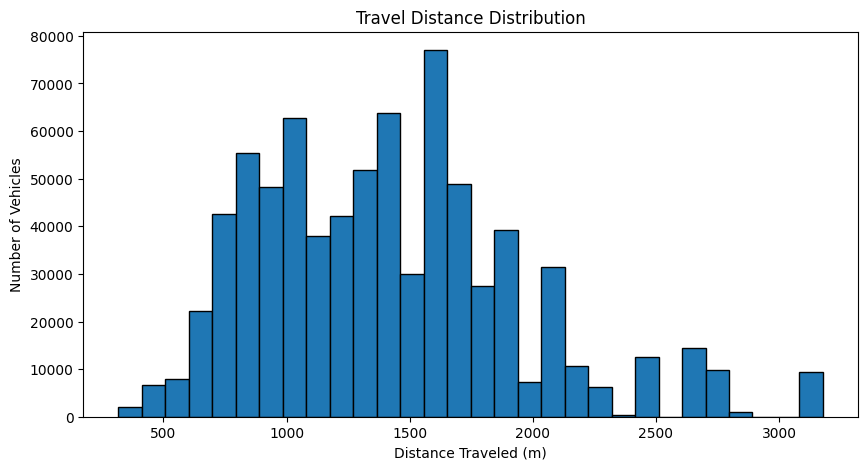

In [116]:
plt.figure(figsize=(10, 5))
plt.hist(df_combined["Distance_Traveled"], bins=30, edgecolor="black")
plt.title("Travel Distance Distribution")
plt.xlabel("Distance Traveled (m)")
plt.ylabel("Number of Vehicles")
plt.show()

## **Time Loss Due to Congestion**
This histogram represents **time lost by vehicles due to congestion**.

#### **Trend Analysis**
- **Most vehicles lose <100s**: Suggests moderate traffic conditions.
- **Smaller peaks at 200s, 300s, and 600s**: Indicates congestion at specific points.
- **Long tail beyond 400s**: Some vehicles experience significant delays.

Understanding time loss helps in **optimizing traffic signals and reducing bottlenecks**.

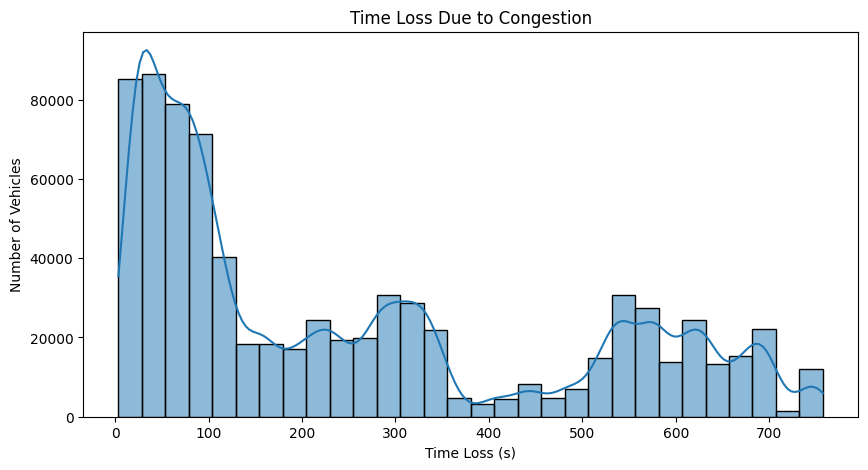

In [118]:
plt.figure(figsize=(10, 5))
sns.histplot(df_combined["Time_Loss"], bins=30, kde=True)
plt.title("Time Loss Due to Congestion")
plt.xlabel("Time Loss (s)")
plt.ylabel("Number of Vehicles")
plt.show()

## **Distance Traveled vs. Time Loss**
This scatter plot shows the relationship between **distance traveled** and **time lost due to congestion**.

#### **Trend Analysis**
- **Majority of points cluster at low time loss**: Most vehicles experience minimal delays.
- **Higher time loss at varied distances**: Some vehicles travel shorter distances but still face congestion.
- **Scattered delays beyond 1500m**: Suggests **localized congestion zones** affecting longer trips.

This helps identify **traffic bottlenecks** and **optimize routing strategies**.

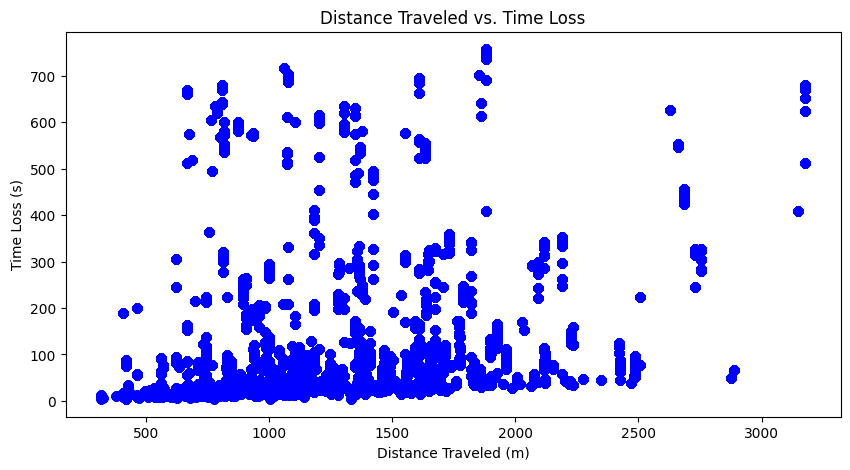

In [120]:
plt.figure(figsize=(10, 5))
plt.scatter(df_combined["Distance_Traveled"], df_combined["Time_Loss"], alpha=0.5, color="blue")
plt.title("Distance Traveled vs. Time Loss")
plt.xlabel("Distance Traveled (m)")
plt.ylabel("Time Loss (s)")
plt.show()

## **Hexbin Plot: Distance Traveled vs. Time Loss**
This hexbin plot shows the density of vehicles experiencing **different levels of time loss** based on **distance traveled**.

#### **Trend Analysis**
- **Dense clustering at low time loss**: Most vehicles experience minimal delays.
- **High congestion points (dark regions)**: Indicates specific **distance ranges with frequent delays**.
- **Scattered high time-loss cases**: Some vehicles face **long delays despite varied trip distances**.

This visualization helps identify **traffic congestion hotspots** and optimize **signal timings**

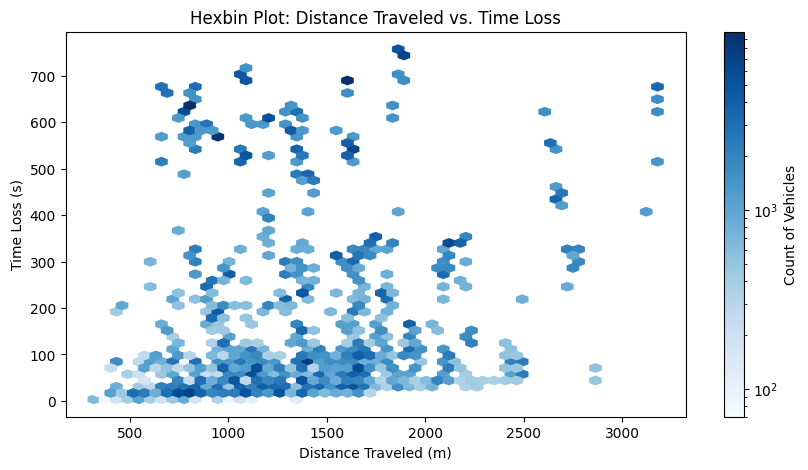

In [122]:
plt.figure(figsize=(10, 5))
plt.hexbin(df_combined["Distance_Traveled"], df_combined["Time_Loss"], gridsize=50, cmap="Blues", bins="log")
plt.colorbar(label="Count of Vehicles")
plt.title("Hexbin Plot: Distance Traveled vs. Time Loss")
plt.xlabel("Distance Traveled (m)")
plt.ylabel("Time Loss (s)")
plt.show()

## **Distance Traveled vs. Waiting Time**
This scatter plot shows how **waiting time** varies with **distance traveled**.

#### **Trend Analysis**
- **Most vehicles have low waiting times**: Suggests efficient traffic flow for many.
- **Clusters of high waiting times**: Indicates **congestion at specific distances**.
- **Scattered high-wait cases**: Some vehicles wait excessively, possibly due to **traffic signals or congestion bottlenecks**.

This helps in **identifying areas where signal timing adjustments** can reduce delays.

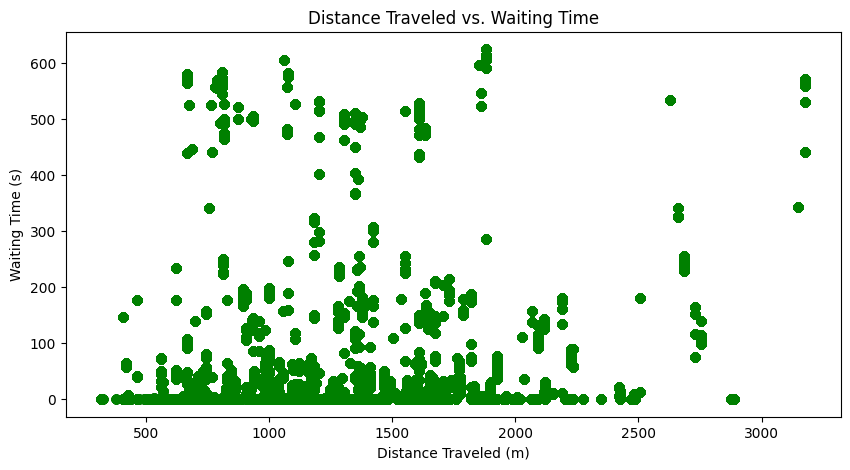

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(df_combined["Distance_Traveled"], df_combined["Waiting_Time"], alpha=0.5, color="green")
plt.title("Distance Traveled vs. Waiting Time")
plt.xlabel("Distance Traveled (m)")
plt.ylabel("Waiting Time (s)")
plt.show()

In [11]:
# Create bins for Distance Traveled
df_combined["Distance_Bin"] = pd.cut(df_combined["Distance_Traveled"], bins=np.linspace(0, df_combined["Distance_Traveled"].max(), 20))

# Compute average waiting time and time loss for each distance bin
df_grouped = df_combined.groupby("Distance_Bin").agg({"Waiting_Time": "mean", "Time_Loss": "mean"}).reset_index()

# Convert bin labels to string for better visualization
df_grouped["Distance_Bin"] = df_grouped["Distance_Bin"].astype(str)

C:\Users\Pushp Raj Choudhary\AppData\Local\Temp\ipykernel_10424\4023409914.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_combined.groupby("Distance_Bin").agg({"Waiting_Time": "mean", "Time_Loss": "mean"}).reset_index()


## **Average Waiting Time and Time Loss vs. Distance Traveled**
This dual-axis plot shows how **average waiting time** (blue) and **time loss** (red) vary across different travel distances.

#### **Trend Analysis**
- **Both waiting time and time loss increase with distance**: Suggests longer trips experience more delays.
- **Fluctuations in mid-range distances**: Likely due to **traffic signals and congestion patterns**.
- **Sharp peaks at higher distances**: Indicates **specific high-delay zones**, possibly due to **network bottlenecks or signal inefficiencies**.

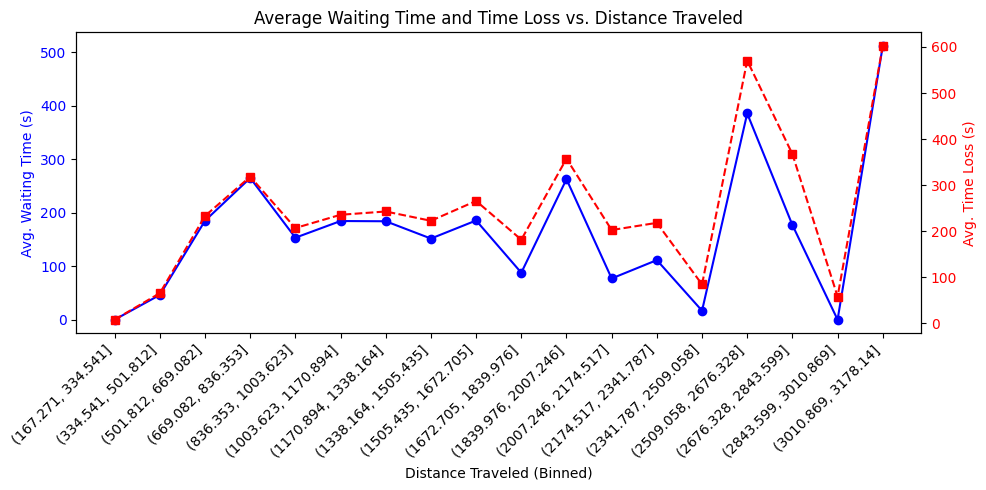

In [126]:
# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel("Distance Traveled (Binned)")
ax1.set_ylabel("Avg. Waiting Time (s)", color="blue")
ax1.plot(df_grouped["Distance_Bin"], df_grouped["Waiting_Time"], marker="o", linestyle="-", color="blue", label="Avg. Waiting Time")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Avg. Time Loss (s)", color="red")
ax2.plot(df_grouped["Distance_Bin"], df_grouped["Time_Loss"], marker="s", linestyle="--", color="red", label="Avg. Time Loss")
ax2.tick_params(axis="y", labelcolor="red")

fig.autofmt_xdate(rotation=45)
plt.title("Average Waiting Time and Time Loss vs. Distance Traveled")
fig.tight_layout()
plt.show()

## **Lane Occupancy Stacked Area Plot**
This stacked area plot visualizes **vehicle occupancy across lane groups over time**.

#### **Trend Analysis**
- **Sharp rise in occupancy initially**: Traffic builds up rapidly, peaking around **timestep ~1500**.
- **Congestion clears after the peak**: Indicates improved traffic flow after **timestep ~2000**.
- **Higher occupancy in certain lane groups**: Some lanes consistently handle more vehicles, suggesting **major traffic corridors**.
- **Gradual reduction to near-zero levels**: Indicates the **end of simulation or reduced demand**.

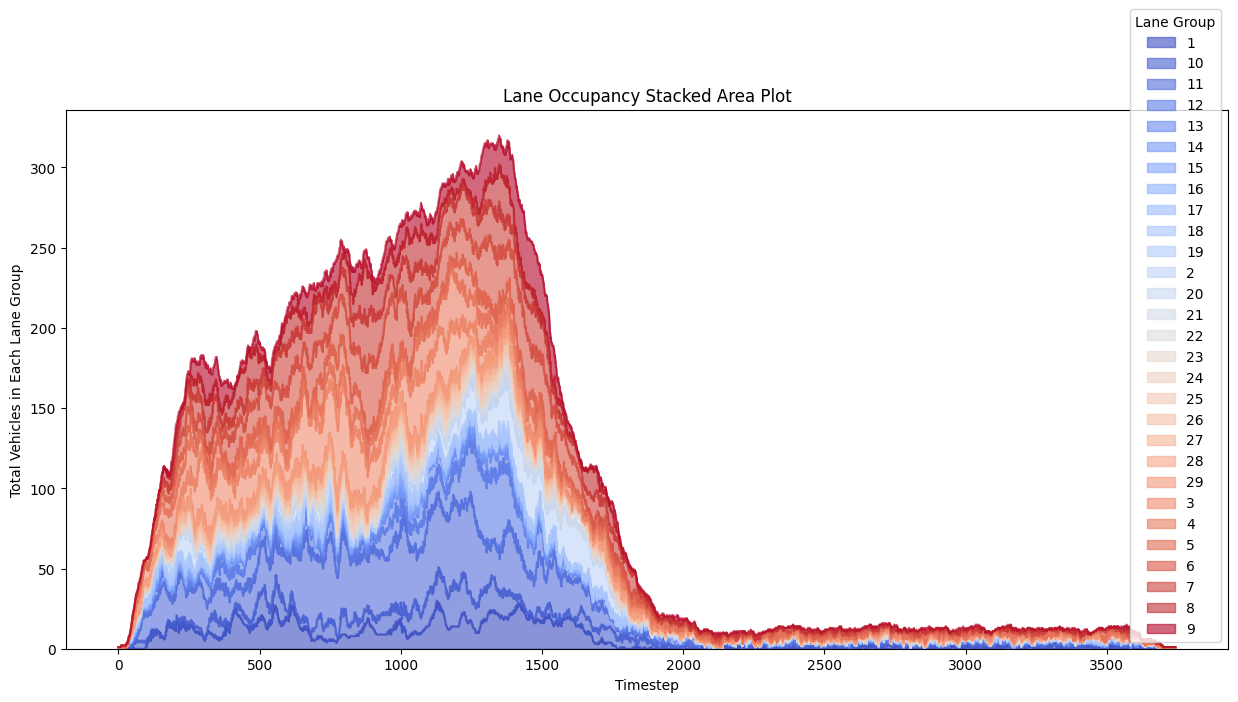

In [80]:
pivot_occupancy = df_combined.pivot_table(index="Timestep", columns="Lane_Group", values="Vehicle_ID", aggfunc="count").fillna(0)
pivot_occupancy.plot(kind="area", stacked=True, figsize=(15, 7), colormap="coolwarm", alpha=0.6)
plt.title("Lane Occupancy Stacked Area Plot")
plt.xlabel("Timestep")
plt.ylabel("Total Vehicles in Each Lane Group")
plt.legend(title="Lane Group")
plt.show()

## **Lane Occupancy Distribution (Violin Plot)**
This violin plot visualizes **the distribution of vehicle occupancy** across different lane groups.

#### **Trend Analysis**
- **Some lanes show high occupancy peaks**: Suggesting they handle **heavy traffic loads**.
- **Narrow distributions in some lanes**: Indicates **consistent low traffic flow**.
- **Wide spread in occupancy for certain lanes**: Implies **fluctuating vehicle density**, possibly due to traffic light timing or congestion patterns.

C:\Users\Pushp Raj Choudhary\AppData\Local\Temp\ipykernel_7884\3679741223.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Lane_Group", y="Vehicle_ID", data=lane_occupancy_violin, palette="coolwarm")


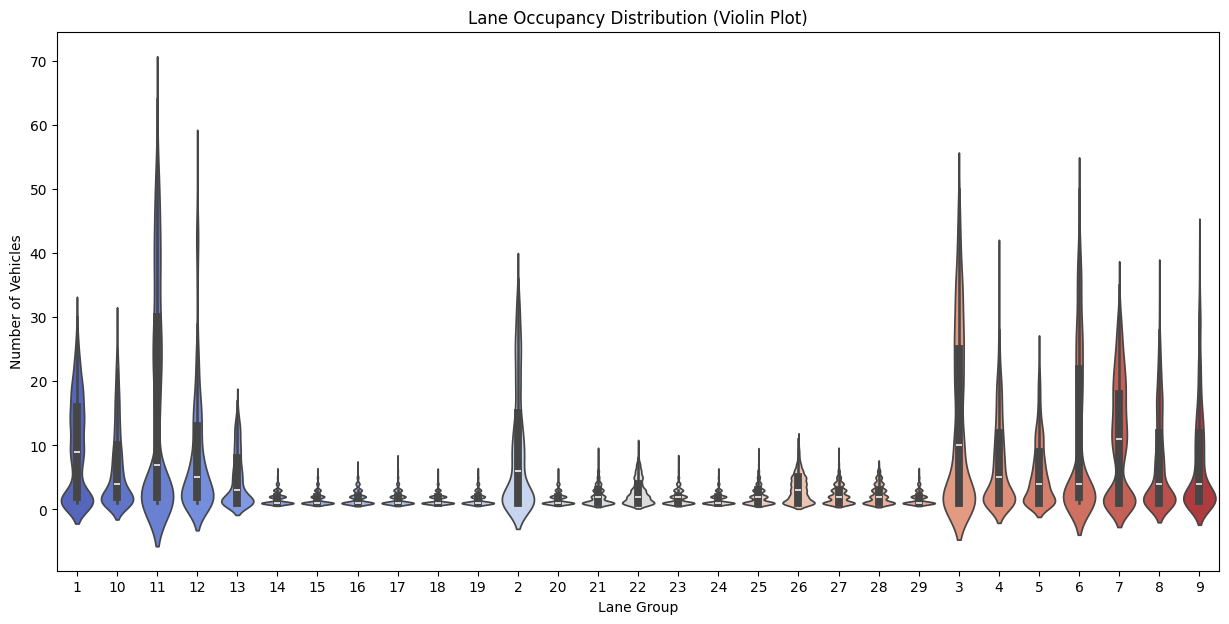

In [81]:
plt.figure(figsize=(15, 7))
lane_occupancy_violin = df_combined.groupby(["Lane_Group", "Timestep"])["Vehicle_ID"].count().reset_index()
sns.violinplot(x="Lane_Group", y="Vehicle_ID", data=lane_occupancy_violin, palette="coolwarm")
plt.title("Lane Occupancy Distribution (Violin Plot)")
plt.xlabel("Lane Group")
plt.ylabel("Number of Vehicles")
plt.show()

## **Waiting Time Distribution**
This histogram shows the **distribution of vehicle waiting times** across the network.

#### **Trend Analysis**
- **Sharp peak near 0s**: Most vehicles experience **minimal waiting time**.
- **Gradual decline for higher wait times**: Fewer vehicles have extended delays.
- **Multiple smaller peaks (100s - 500s)**: Indicates periodic **traffic signal delays or congestion zones**.

#### **Why Is This Useful?**
- Helps detect **bottlenecks causing excessive delays**.
- Identifies **inefficiencies in traffic light timing**.
- Supports **optimization of flow for reduced waiting times**.

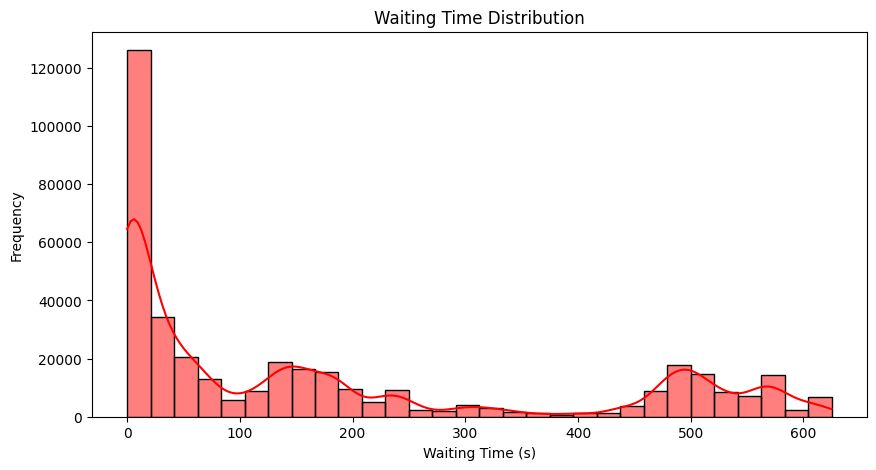

In [60]:
plt.figure(figsize=(10, 5))
sns.histplot(df_combined["Waiting_Time"], bins=30, kde=True, color="red")
plt.title("Waiting Time Distribution")
plt.xlabel("Waiting Time (s)")
plt.ylabel("Frequency")
plt.show()

## **Emissions Over Time**
These line plots visualize **the variation in CO2, NOx, and PMx emissions and the fuel consumption** throughout the simulation.

#### **Trend Analysis**
- **Initial high spike in emissions**: Likely due to a sudden influx of vehicles accelerating from rest.
- **Stable phase in the middle**: Indicates a period of **steady traffic flow with moderate emissions**.
- **Gradual increase after timestep ~1800**: Suggests **growing congestion** leading to more fuel consumption.
- **Spikes towards the end**: Could be due to **stop-and-go traffic, traffic light delays, or increased vehicle density**.

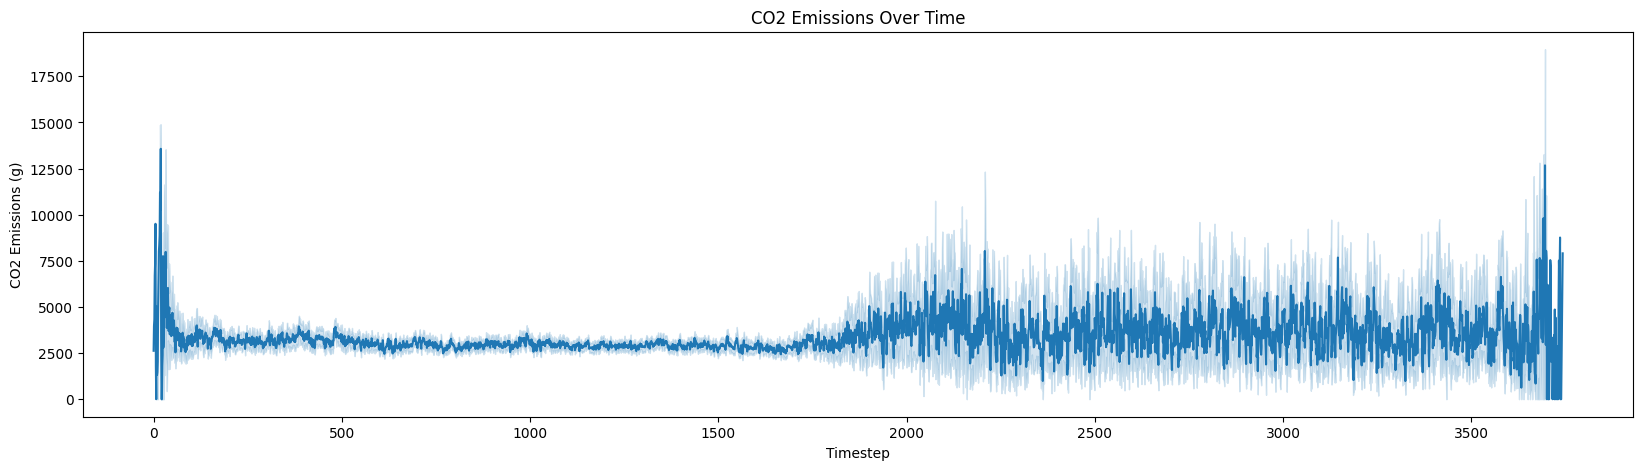

In [62]:
plt.figure(figsize=(20, 5))
sns.lineplot(x="Timestep", y="CO2_Emission", data=df_combined)
plt.title("CO2 Emissions Over Time")
plt.xlabel("Timestep")
plt.ylabel("CO2 Emissions (g)")
plt.show()

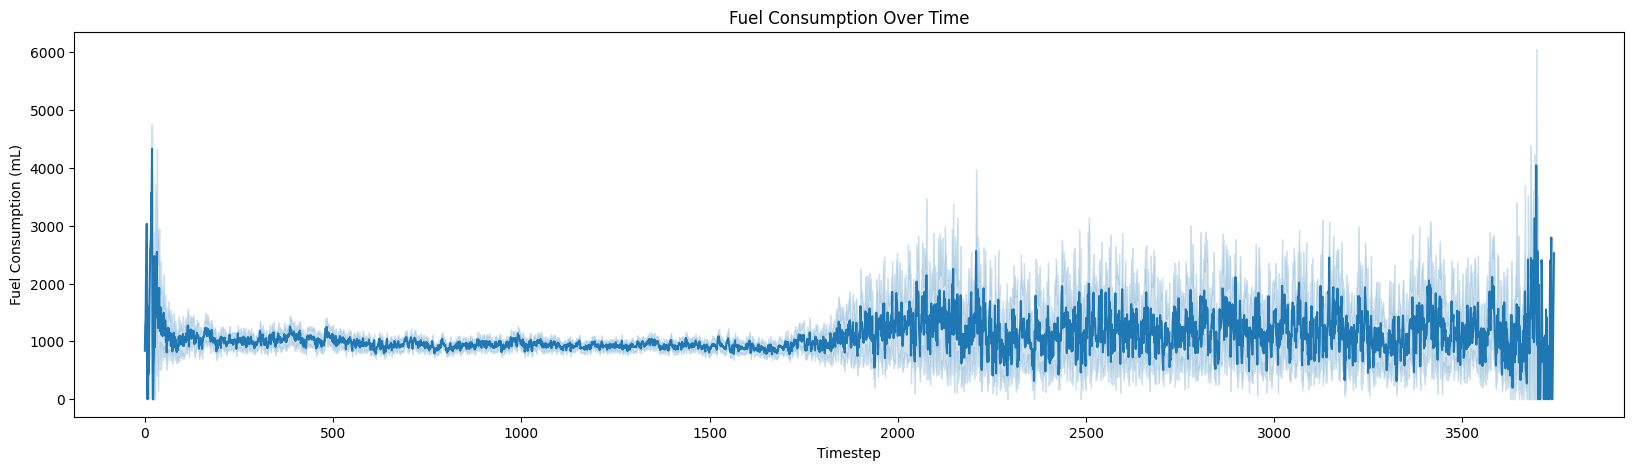

In [72]:
plt.figure(figsize=(20, 5))
sns.lineplot(x="Timestep", y="Fuel_Consumption", data=df_combined)
plt.title("Fuel Consumption Over Time")
plt.xlabel("Timestep")
plt.ylabel("Fuel Consumption (mL)")
plt.show()

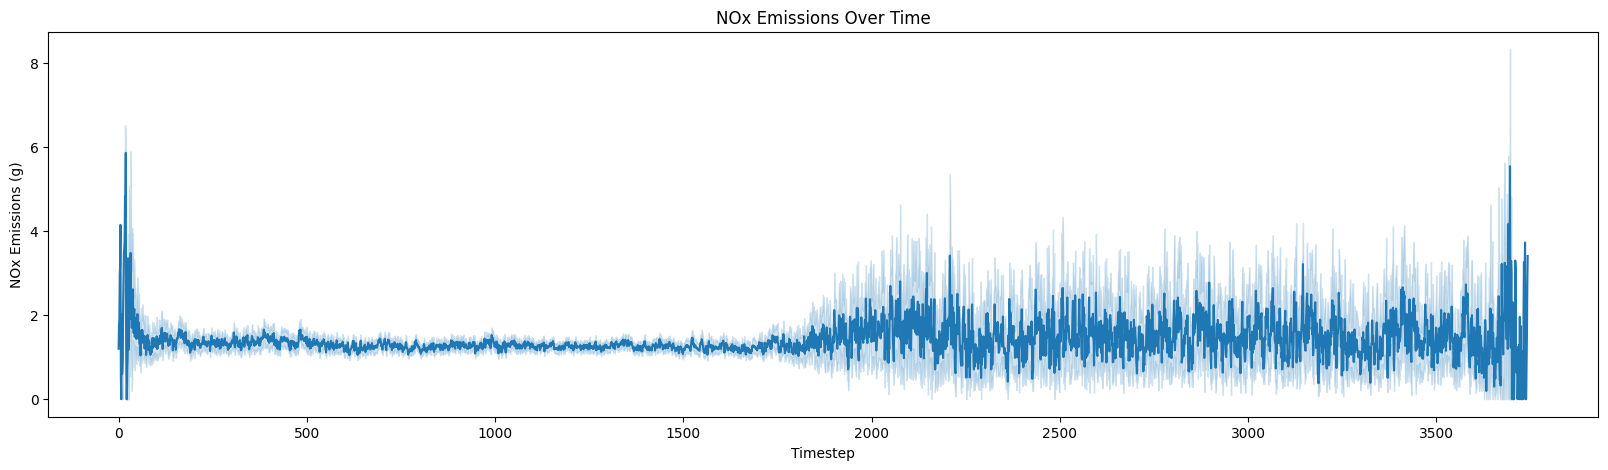

In [73]:
plt.figure(figsize=(20, 5))
sns.lineplot(x="Timestep", y="NOx_Emission", data=df_combined)
plt.title("NOx Emissions Over Time")
plt.xlabel("Timestep")
plt.ylabel("NOx Emissions (g)")
plt.show()

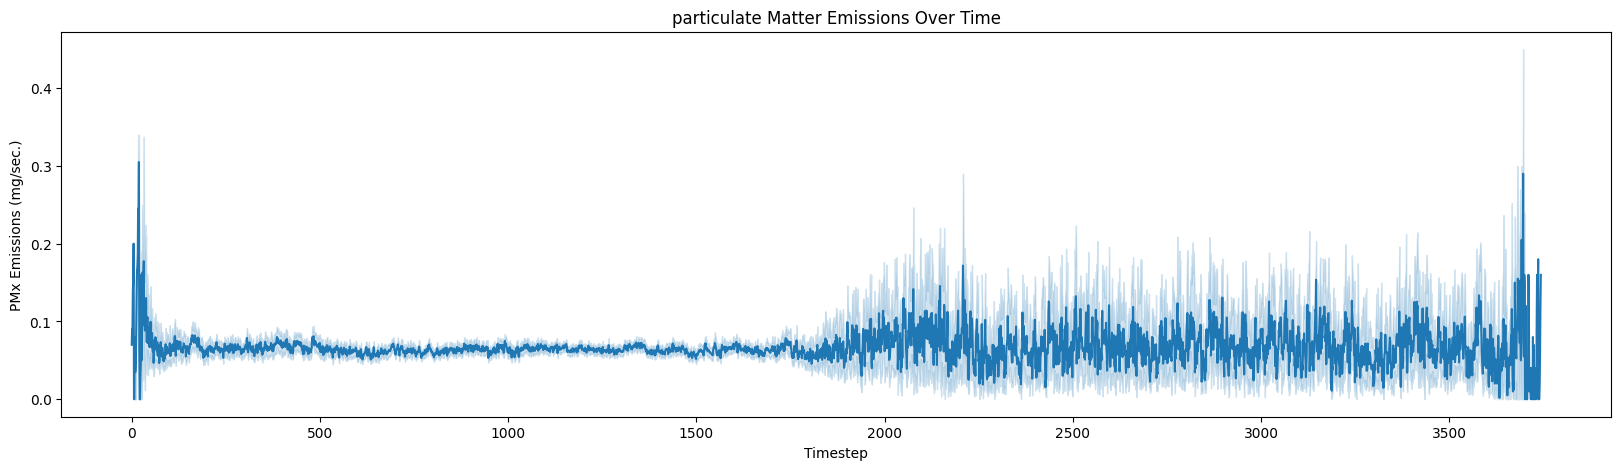

In [74]:
plt.figure(figsize=(20, 5))
sns.lineplot(x="Timestep", y="PMx_Emission", data=df_combined)
plt.title("particulate Matter Emissions Over Time")
plt.xlabel("Timestep")
plt.ylabel("PMx Emissions (mg/sec.)")
plt.show()

## **Comparison of Green and Red Light Durations**
This bar chart compares the **average durations** of **green** and **red** phases for different traffic lights (2 in our case).

#### **Trend Analysis**
- **Green light durations are significantly longer than red lights**: Indicates a possible attempt to maximize throughput.
- **Short red light durations**: Could lead to frequent signal changes, which may cause **stop-and-go traffic**.
- **Uniform green phase durations**: Suggests a **fixed-time control strategy** rather than an adaptive system.

#### **Why Is This Useful?**
- **Traffic Flow Optimization**: Identifies **imbalances** in phase durations that may cause congestion.
- **Adaptive Signal Control**: Helps determine if **green light durations should be adjusted** based on traffic density.
- **Bottleneck Identification**: Short red lights might not allow enough time for proper queue clearance, leading to **backups at intersections**.

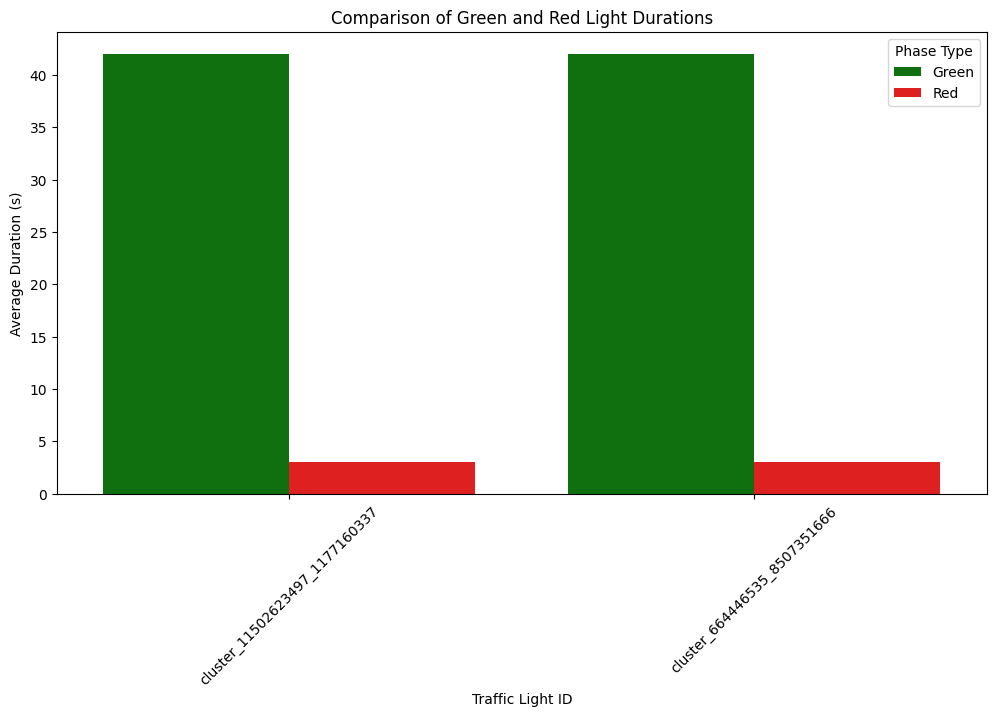

In [103]:
df_traffic_lights["Phase_Type"] = df_traffic_lights["State"].apply(lambda x: "Green" if "G" in x else "Red")

# Group by traffic light and phase type
phase_avg = df_traffic_lights.groupby(["Traffic_Light_ID", "Phase_Type"])["Phase_Duration"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x="Traffic_Light_ID", y="Phase_Duration", hue="Phase_Type", data=phase_avg, palette={"Green": "green", "Red": "red"})
plt.title("Comparison of Green and Red Light Durations")
plt.xlabel("Traffic Light ID")
plt.ylabel("Average Duration (s)")
plt.xticks(rotation=45)
plt.legend(title="Phase Type")
plt.show()

## **Number of State Changes Per Traffic Light**
This bar chart represents the **number of times each traffic light changed state** during the simulation.

#### **Trend Analysis**
- **Equal number of state changes across traffic lights**: Suggests a **fixed-timing signal system** rather than an adaptive one.
- **Higher state change counts would indicate frequent switching**, which can **increase stop-and-go traffic and fuel consumption**.
- **Low variation in state changes**: Indicates all signals follow **a predefined cycle rather than demand-based control**.

#### **Why Is This Useful?**
- **Helps evaluate signal efficiency**: Too many state changes can lead to **traffic instability**, while too few may cause **long waiting times**.
- **Identifies potential improvements**: Adaptive signals could **reduce unnecessary stops and improve traffic flow**.
- **Aids in congestion management**: Adjusting **state change frequency** could improve **overall network throughput**.

C:\Users\Pushp Raj Choudhary\AppData\Local\Temp\ipykernel_7884\2232849392.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Traffic_Light_ID", y="State_Change_Count", data=state_change_counts, palette="coolwarm")


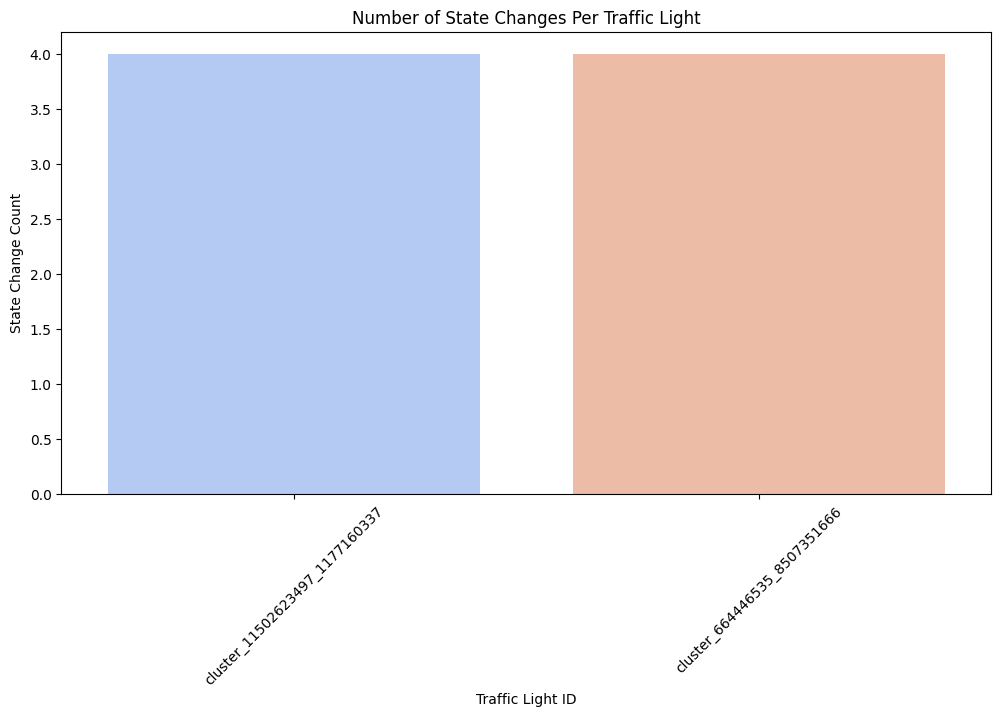

In [104]:
state_change_counts = df_traffic_lights.groupby("Traffic_Light_ID")["State"].nunique().reset_index()
state_change_counts.columns = ["Traffic_Light_ID", "State_Change_Count"]

plt.figure(figsize=(12, 6))
sns.barplot(x="Traffic_Light_ID", y="State_Change_Count", data=state_change_counts, palette="coolwarm")
plt.title("Number of State Changes Per Traffic Light")
plt.xlabel("Traffic Light ID")
plt.ylabel("State Change Count")
plt.xticks(rotation=45)
plt.show()

## **Number of State Changes Per Traffic Light**
This bar chart displays how many times each traffic light **changed its state** during the simulation.

#### **Trend Analysis**
- **Equal number of state changes across lights**: Suggests a **fixed-time control system** rather than an adaptive one.
- **Limited state changes (only 4 per signal)**: Indicates **longer phase durations**, possibly leading to **long vehicle queues** at peak times.
- **No major variation in state counts**: Means that traffic signals are **not dynamically adjusting to congestion levels**.

#### **Why Is This Useful?**
- **Traffic Efficiency Assessment**: Helps determine if **state changes are optimal** for current traffic conditions.
- **Potential for Adaptive Control**: Too few changes may cause **long delays**, while too many can result in **unnecessary stops**.
- **Supports Intelligent Traffic Management**: Insights from state change frequency can guide **improvements in signal timing algorithms**.

C:\Users\Pushp Raj Choudhary\AppData\Local\Temp\ipykernel_7884\243908270.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Traffic_Light_ID", y="Waiting_Time", data=waiting_per_light, palette='dark')


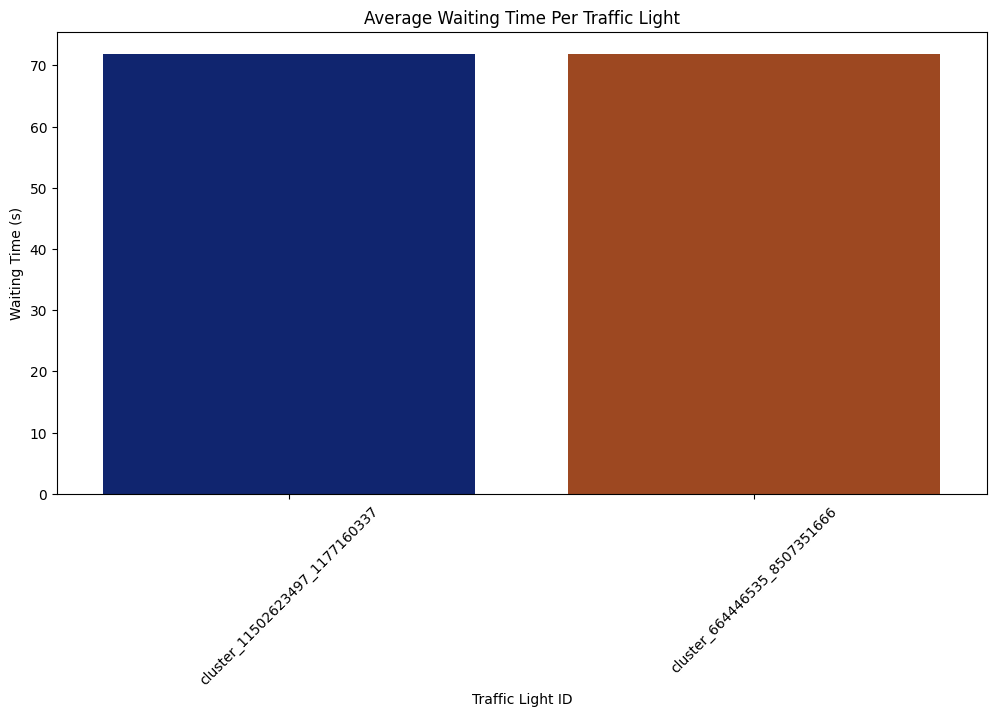

In [107]:
# Merge traffic light data with trip waiting times
df_tls_waiting = df_traffic_lights.merge(df_trip, left_on="Timestep", right_on="Depart_Time", how="left")

# Calculate average waiting time per traffic light
waiting_per_light = df_tls_waiting.groupby("Traffic_Light_ID")["Waiting_Time"].mean().reset_index()

# Plot results
plt.figure(figsize=(12, 6))
sns.barplot(x="Traffic_Light_ID", y="Waiting_Time", data=waiting_per_light, palette='dark')
plt.title("Average Waiting Time Per Traffic Light")
plt.xlabel("Traffic Light ID")
plt.ylabel("Waiting Time (s)")
plt.xticks(rotation=45)
plt.show()

**The following code is not executed in this notebook. The RL model implementation is being developed in a separate notebook for proper documentation. The code below serves only as a reference to illustrate how further analysis and model training will be conducted based on the data obtained in this file and the analysis performed here.**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import pandas as pd
from collections import deque

### Neural Network for DQN (if this model overfit or is found to be complex, I'll reduce the layers or shift to other model)

In [ ]:
# Define Neural Network Model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

### **State Space for RL Traffic Light Optimization**
The **state space** is constructed using extracted traffic parameters from CSV files.

#### **Final Selected Features**
1. **Vehicle Density** (from `fcd_output.csv`): Number of vehicles in each lane.
2. **Waiting Time** (from `tripinfo.csv`): How long vehicles remain stopped at signals.
3. **Traffic Flow** (from `tripinfo.csv`): Distance traveled by vehicles in a given period.
4. **Fuel Consumption** (from `emission.csv`): Fuel usage per vehicle (replaces CO₂ emissions).

#### **Why These Features?**
- **Queue length estimation** requires lane-wise aggregation of vehicle count.
- **Traffic flow and waiting time directly impact efficiency**.
- **Fuel consumption optimization leads to economic and environmental benefits**.

### **Action Space in RL for Traffic Light Optimization**
In our Deep Q-Network (DQN)-based traffic light optimization, the **action space** represents the possible decisions the RL agent can make to control traffic lights at intersections.

#### **Types of Actions**
The agent can take the following actions:
1. **Switch to the Next Traffic Phase**: Change the signal to the next predefined phase.
2. **Increase Green Light Duration**: Extend the green light for the current phase.
3. **Decrease Green Light Duration**: Reduce the green light time for the current phase.
4. **Switch Directly to the Least Congested Phase**: Override phase order and switch to the least congested lane.

#### **Discrete Action Representation**
For a typical intersection with **N** possible signal phases, the action space is discrete:
- **0**: Maintain current phase
- **1**: Switch to the next phase
- **2**: Extend green phase time
- **3**: Reduce green phase time

If the intersection has **multiple lanes with different phases**, we can extend this to allow phase-specific actions.

#### **Why This Matters?**
- **Dynamic Adjustments**: Traditional traffic lights use fixed timings, while RL optimizes real-time adjustments.
- **Minimizing Congestion**: The RL model learns when to switch signals for minimal queue buildup.
- **Reducing Emissions**: Optimized traffic flow leads to fewer stops, reducing vehicle emissions.

### DQN Agent 

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000) 
        self.epsilon = 1.0  # Exploration rate
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()

    def store_experience(self, state, action, reward, next_state, done):
        """ Store experience for replay """
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        """ Epsilon-greedy policy for action selection """
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, self.action_size - 1)  # Random action (exploration)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return torch.argmax(q_values).item()  # Greedy action (exploitation)

    def train_model(self):
        """ Train the DQN using experience replay """
        if len(self.memory) < 32:
            return

        batch = random.sample(self.memory, 32)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        with torch.no_grad():
            target_q_values = rewards + 0.95 * torch.max(self.model(next_states), dim=1)[0] * (1 - dones)

        current_q_values = self.model(states).gather(1, actions).squeeze()
        loss = self.criterion(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay exploration rate
        if self.epsilon > 0.01:
            self.epsilon *= 0.995

**The above is all the code I have written in the other file and will be optimizing this code after some literature review and more insights on RL.**